# A template for future assignments

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os
import pdb

### Handling the data

In [11]:
# I am a big fan of config files and I believe it is a good practise
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])


config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [6]:
# may differ depending on the problem
transform = transforms.Compose(
    [transforms.ToTensor(),
     ]) # put more transforms options here

In [27]:
#load datasets (in the future it's possible that the whole process will be in a 
#separate file)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [28]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [29]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


### We can display some images from the dataset
Functions used will probably vastly differ from task to task

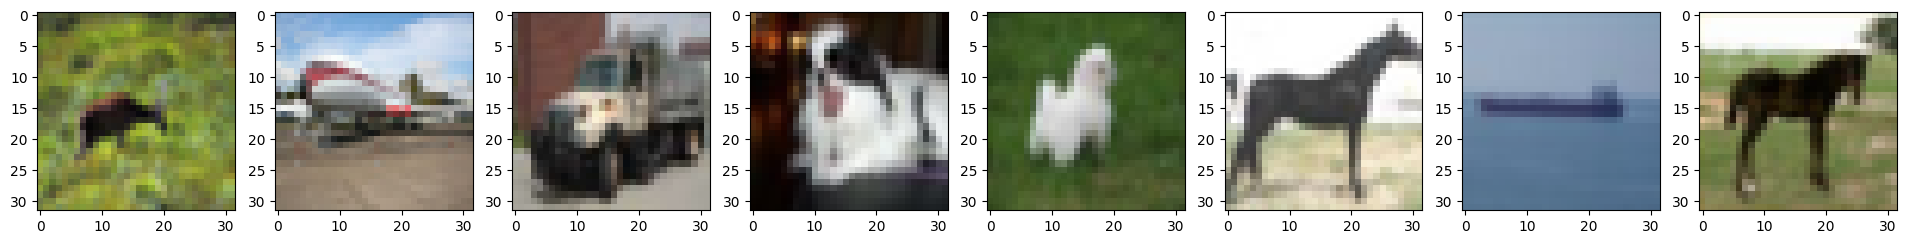

In [45]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,32,32).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

### Creating the model

In [46]:
class Model(nn.Module):
    """
    DESCRIPTION
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Training the model

In [47]:
from tqdm import tqdm

In [48]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=3072, hidden_dim=512, output_dim=10)
model = model.to(device)

In [91]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training loop

In [92]:
# For saving models and checkpoints later
if(not os.path.exists("models")):
    os.makedirs("models")

torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
torch.Size

In [94]:
train_loss_list = []
test_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # Evaluate test data
                # Calculate test loss, accuracy for currently trained model
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images_test, labels_test = data
                # using GPU for inference
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                # Flatten images
                flattened_images_test = images_test.flatten(start_dim=1)
                # calculate model outputs
                outputs_test = model(flattened_images_test)
                # calculate test loss
                loss = criterion(outputs_test, labels_test)
                test_loss += loss.item()
                # derive model predictions from out outputs
                predicted = torch.argmax(outputs_test, dim = -1)
                # calculate accuracy
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

            test_loss /= len(testloader)
            accuracy = 100 * correct / total

            print(f'test_loss: {test_loss}')
            print(f'accuracy: {accuracy}')

        test_loss_list.append(test_loss)
        test_accuracy_list.append(accuracy)
        # Turn model back to training mode
        model.train()
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list.append(loss.item())

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint


        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 1 Iter 1: loss 2.30915. :   0%|          | 1/782 [00:11<2:26:44, 11.27s/it]

test_loss: 2.3192090077005374
accuracy: 9.89


Epoch 1 Iter 1: loss 2.30915. :   0%|          | 2/782 [00:16<1:40:07,  7.70s/it]

test_loss: 2.4382445964084307
accuracy: 10.07


Epoch 1 Iter 1: loss 2.30915. :   0%|          | 3/782 [00:21<1:25:23,  6.58s/it]

test_loss: 2.362721370283965
accuracy: 15.42


Epoch 1 Iter 1: loss 2.30915. :   1%|          | 4/782 [00:27<1:21:18,  6.27s/it]

test_loss: 2.370976882375729
accuracy: 12.29


Epoch 1 Iter 1: loss 2.30915. :   1%|          | 5/782 [00:33<1:18:51,  6.09s/it]

test_loss: 2.3777205063279268
accuracy: 10.14


Epoch 1 Iter 1: loss 2.30915. :   1%|          | 6/782 [00:39<1:17:45,  6.01s/it]

test_loss: 2.3237883664999797
accuracy: 12.05


Epoch 1 Iter 1: loss 2.30915. :   1%|          | 7/782 [00:44<1:15:33,  5.85s/it]

test_loss: 2.268184551008188
accuracy: 14.74


Epoch 1 Iter 1: loss 2.30915. :   1%|          | 8/782 [00:50<1:15:15,  5.83s/it]

test_loss: 2.243697016102493
accuracy: 17.14


Epoch 1 Iter 1: loss 2.30915. :   1%|          | 9/782 [00:56<1:17:12,  5.99s/it]

test_loss: 2.2392914067408083
accuracy: 16.5


Epoch 1 Iter 1: loss 2.30915. :   1%|▏         | 10/782 [01:02<1:16:58,  5.98s/it]

test_loss: 2.242244761460906
accuracy: 15.15


Epoch 1 Iter 11: loss 2.26115. :   1%|▏         | 11/782 [01:08<1:15:52,  5.90s/it]

test_loss: 2.241925881926421
accuracy: 15.36


Epoch 1 Iter 11: loss 2.26115. :   1%|▏         | 11/782 [01:13<1:25:23,  6.65s/it]


KeyboardInterrupt: 

evaluating the model

In [71]:
tl = testloader
x = next(iter(testloader))
x[0].shape
len(testloader)

157

In [61]:
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
        
        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 157/157 [00:01<00:00, 90.35it/s] 

Test accuracy: 47.86%


# Evaluation without hyperparameter optimization
Here we achieved an accuracy of 47.86%. Considering we are working with 10 classes, this is still a lot better than random. Nevertheless, we hope that we can optimize the results even further with the hyperparameter optimization

### Visualizing the results

In [59]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

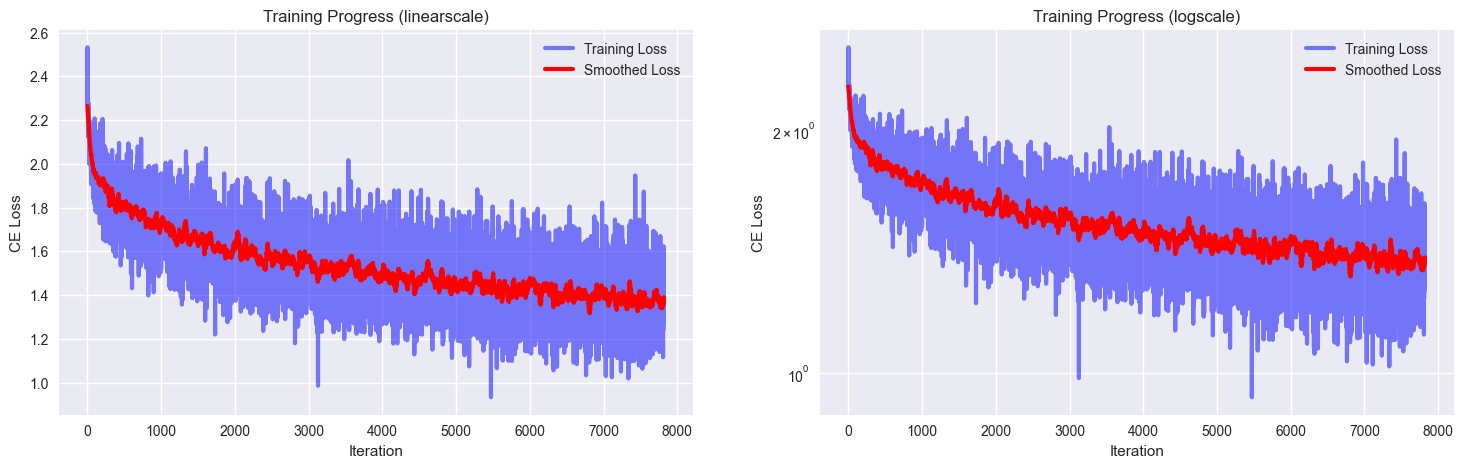

In [60]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(loss_list, 31)
ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()